In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def c_pdd(rho):
    c = 0
    for i in np.diag(rho):
        for j in np.diag(rho):
            c += abs(i-j)
    c /= (2*np.diag(rho).shape[0]-2)
    c = 1 - c
    return c


def von_neumann_entropy(rho):
    # Calculate eigenvalues of the density matrix
    eigenvalues = np.linalg.eigvals(rho)
    
    # Filter out non-positive eigenvalues to avoid log issues
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Calculate the von Neumann entropy
    entropy = -np.sum(eigenvalues * np.log(eigenvalues))
    
    return entropy

def relative_entropy_of_coherence(rho):
    # Calculate the diagonal part of the density matrix
    rho_diag = np.diag(np.diag(rho))
    
    # Calculate the von Neumann entropy of the original density matrix
    S_rho = von_neumann_entropy(rho)
    
    # Calculate the von Neumann entropy of the diagonal density matrix
    S_rho_diag = von_neumann_entropy(rho_diag)
    
    # The relative entropy of coherence
    C_rel_ent = S_rho_diag - S_rho
    C_rel_ent /= np.log(rho.shape[0])
       
    return C_rel_ent


def l1_norm_of_coherence(rho):
    """Calculates the normalized L1 norm of coherence for a given density matrix.
    
    Args:
        rho (np.ndarray): The density matrix (NxN).
    
    Returns:
        float: The normalized L1 norm of coherence.
    """
    # Ensure the density matrix is square
    assert rho.shape[0] == rho.shape[1], "Density matrix must be square"
    
    # Dimension of the density matrix
    N = rho.shape[0]
    
    # Calculate the sum of absolute values of the off-diagonal elements
    raw_coherence = np.sum(np.abs(rho)) - np.sum(np.abs(np.diag(rho)))
    
    # Normalize the coherence
    normalized_coherence = raw_coherence / (N - 1)
    
    return normalized_coherence

In [16]:
H_non_interacting = np.array([
    [0,1,1,0],
    [1,0,0,1],
    [1,0,0,1],
    [0,1,1,0]], dtype = complex
)

H_interacting = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,1,0,0],
    [1,0,0,0]], dtype = complex
)

# H = H/np.linalg.det(H)

p = np.array([
    [1,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]], dtype = complex
)

# p = np.array([
#     [0.25,0.25,0.25,0.25],
#     [0.25,0.25,0.25,0.25],
#     [0.25,0.25,0.25,0.25],
#     [0.25,0.25,0.25,0.25]], dtype = complex
# )

# p = p/np.linalg.det(p)


def evolve_density_matrix(H, rho, dt, steps, n = 2, ptype="", plot = True):
    """Evolves the density matrix using the Liouville-von Neumann equation.
    
    Args:
        H (np.ndarray): The Hamiltonian matrix (4x4).
        rho (np.ndarray): The initial density matrix (4x4).
        dt (float): The time step for evolution.
        steps (int): The number of steps to evolve the system.
        n (int): The number of qubits in the system.
        ptype (str): The type of plot to display.
    
    Returns:
        np.ndarray: The evolved density matrix after the specified number of steps.
    """
    rho = np.zeros((pow(2,n),pow(2,n)), dtype=complex)
    rho[0,0] = 1

    hbar = 1.0  # Use natural units where ħ = 1
    
    # List to store the diagonal elements at each step
    # Initialize a NumPy array to store diagonal elements at each step
    diagonal_elements = np.zeros((steps + 1, rho.shape[0]), dtype=float)
    C_pdd = np.zeros(steps + 1, dtype=float)
    C_l1 = np.zeros(steps + 1, dtype=float)
    C_re = np.zeros(steps + 1, dtype=float)
    
    t = np.linspace(0, steps, steps+1)
    
    for step in range(steps):
        # Store the diagonal elements of the current density matrix
        diagonal_elements[step] = abs(np.diag(rho))
        diagonal_elements[step] /= sum(diagonal_elements[step])

        C_pdd[step] = c_pdd(rho)
        if plot:
            C_l1[step] = l1_norm_of_coherence(rho)
            C_re[step] = relative_entropy_of_coherence(rho)
        
        # Calculate the commutator [H, rho]
        commutator = np.dot(H, rho) - np.dot(rho, H)
        
        # Update the density matrix using the Liouville-von Neumann equation
        rho += (-1j * dt  * commutator / hbar)
        rho /= np.trace(rho)
        
    x = diagonal_elements.transpose()

    if plot:
        plt.figure(figsize=(10, 6))
        # First four scatter plots with low visibility
        plt.plot(t, x[0], linestyle='--', linewidth=0.5, label='00')
        plt.plot(t, x[1], linestyle='--', linewidth=0.5, label='01')
        plt.plot(t, x[2], linestyle='-.', linewidth=0.5, label='10')
        plt.plot(t, x[3], linestyle=':', linewidth=0.5, label='11')
        plt.plot(t, C_pdd, linestyle='-', linewidth=1.5, label='C_pdd') 
        plt.plot(t, C_re, linestyle='-', linewidth=1.5, label='C_re')   
        plt.plot(t, C_l1, linestyle='-', linewidth=1.5, label='C_l1') 
        plt.title(ptype)
        # plt.legend()
        plt.show()
        # plt.scatter(t, x[0], marker = '+')
        # plt.show()
        # plt.scatter(t, x[1])
        # plt.show()
        # plt.scatter(t, x[2])
        # plt.show()
        # plt.scatter(t, x[3])
        # plt.show()
        
    return C_pdd








def evolve_density_matrix_mix(H1, rho1, p1, H2, rho2, p2, dt, steps, n = 2, ptype=""):
    """Evolves the density matrix using the Liouville-von Neumann equation.
    
    Args:
        H1 (np.ndarray): The Hamiltonian matrix for the first state
        rho1 (np.ndarray): The initial density matrix for the first state
        p1 (np.ndarray): The probability of mixing for the first state
        H2 (np.ndarray): The Hamiltonian matrix for the second state
        rho2 (np.ndarray): The initial density matrix for the second state
        p2 (np.ndarray): The probability of mixing for the second state
        dt (float): The time step for evolution.
        steps (int): The number of steps to evolve the system.
        n (int): The number of qubits in the system.
        ptype (str): The type of plot to display.
    
    Returns:
        np.ndarray: The evolved density matrix after the specified number of steps.
    """

    rho1 = np.zeros((pow(2,n),pow(2,n)), dtype=complex)
    rho1[0,0] = 1
    rho2 = np.zeros((pow(2,n),pow(2,n)), dtype=complex)
    rho2[1,1] = 1

    hbar = 1.0  # Use natural units where ħ = 1
    p1 = p1 / (p1**2+p2**2)**0.5
    p2 = p2 / (p1**2+p2**2)**0.5

    # List to store the diagonal elements at each step
    # Initialize a NumPy array to store diagonal elements at each step
    diagonal_elements1 = np.zeros((steps + 1, rho1.shape[0]), dtype=float)
    C_pdd1 = np.zeros(steps + 1, dtype=float)
    C_l11 = np.zeros(steps + 1, dtype=float)
    C_re1 = np.zeros(steps + 1, dtype=float)
    diagonal_elements2 = np.zeros((steps + 1, rho2.shape[0]), dtype=float)
    C_pdd2 = np.zeros(steps + 1, dtype=float)
    C_l12 = np.zeros(steps + 1, dtype=float)
    C_re2 = np.zeros(steps + 1, dtype=float)
    
    t = np.linspace(0, steps, steps+1)
    
    for step in range(steps):
        # Store the diagonal elements of the current density matrix
        diagonal_elements1[step] = abs(np.diag(rho1))
        diagonal_elements1[step] /= sum(diagonal_elements1[step])

        C_pdd1[step] = c_pdd(rho1)
        C_l11[step] = l1_norm_of_coherence(rho1)
        C_re1[step] = relative_entropy_of_coherence(rho1)
        
        # Calculate the commutator [H, rho]
        commutator1 = np.dot(H1, rho1) - np.dot(rho1, H1)
        
        # Update the density matrix using the Liouville-von Neumann equation
        rho1 += (-1j * dt  * commutator1 / hbar)
        rho1 /= np.trace(rho1)
        
        # Store the diagonal elements of the current density matrix
        diagonal_elements2[step] = abs(np.diag(rho2))
        diagonal_elements2[step] /= sum(diagonal_elements2[step])

        C_pdd2[step] = c_pdd(rho2)
        C_l12[step] = l1_norm_of_coherence(rho2)
        C_re2[step] = relative_entropy_of_coherence(rho2)
        
        # Calculate the commutator [H, rho]
        commutator2 = np.dot(H2, rho2) - np.dot(rho2, H2)
        
        # Update the density matrix using the Liouville-von Neumann equation
        rho2 += (-1j * dt  * commutator2 / hbar)
        rho2 /= np.trace(rho2)
        
        
    C_pdd = p1 * C_pdd1 + p2 * C_pdd2
    C_l1 = p1 * C_l11 + p2 * C_l12
    C_re = p1 * C_re1 + p2 * C_re2

    plt.figure(figsize=(10, 6))
    # First four scatter plots with low visibility
    # plt.plot(t, x[0], linestyle='--', linewidth=0.5, label='00')
    # plt.plot(t, x[1], linestyle='--', linewidth=0.5, label='01')
    # plt.plot(t, x[2], linestyle='-.', linewidth=0.5, label='10')
    # plt.plot(t, x[3], linestyle=':', linewidth=0.5, label='11')
    plt.plot(t, C_pdd, linestyle='-', linewidth=1.5, label='C_pdd') 
    plt.plot(t, C_re, linestyle='-', linewidth=1.5, label='C_re')   
    plt.plot(t, C_l1, linestyle='-', linewidth=1.5, label='C_l1') 
    plt.title(ptype)
    plt.legend()
    plt.show()
    # plt.scatter(t, x[0], marker = '+')
    # plt.show()
    # plt.scatter(t, x[1])
    # plt.show()
    # plt.scatter(t, x[2])
    # plt.show()
    # plt.scatter(t, x[3])
    # plt.show()
    
    # return diagonal_elements


# diagonal_elements = evolve_density_matrix(H_non_interacting, p, 0.0001, 50000)
# diagonal_elements = evolve_density_matrix(H_interacting, p, 0.0001, 50000)

# print(p)
# print(diagonal_elements)

C:\Users\91953\AppData\Local\Temp\ipykernel_20640\1943827306.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  C_re[step] = relative_entropy_of_coherence(rho)


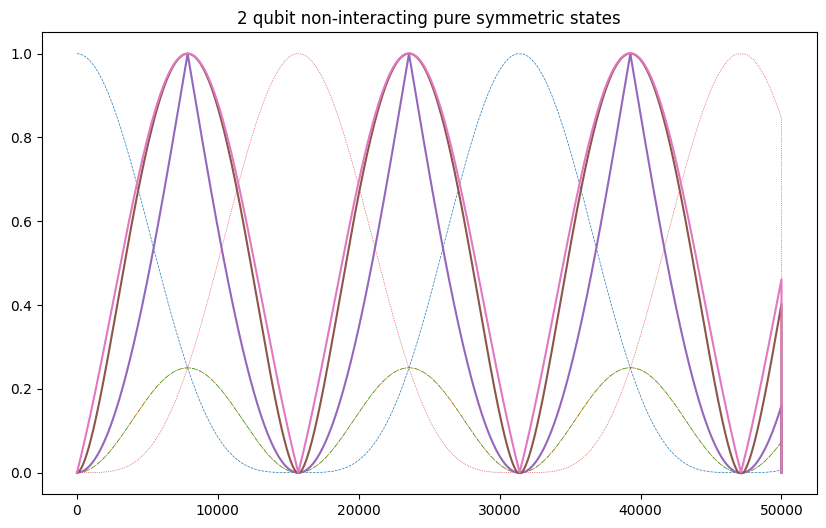

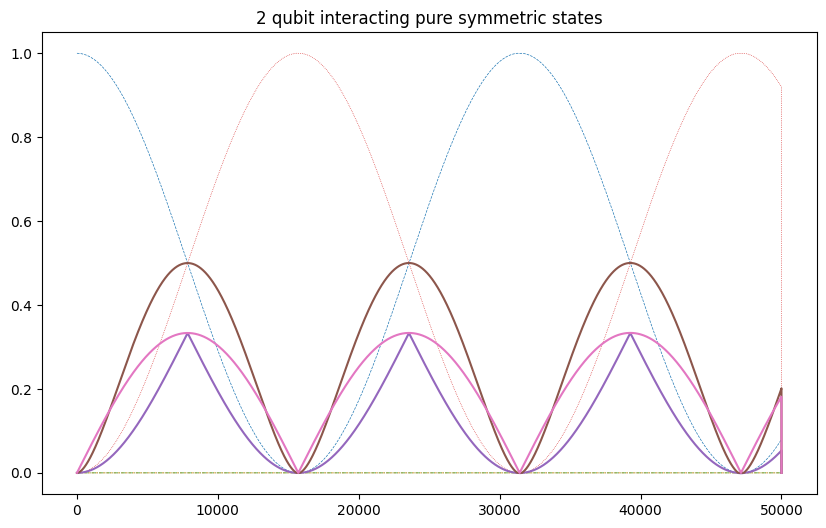

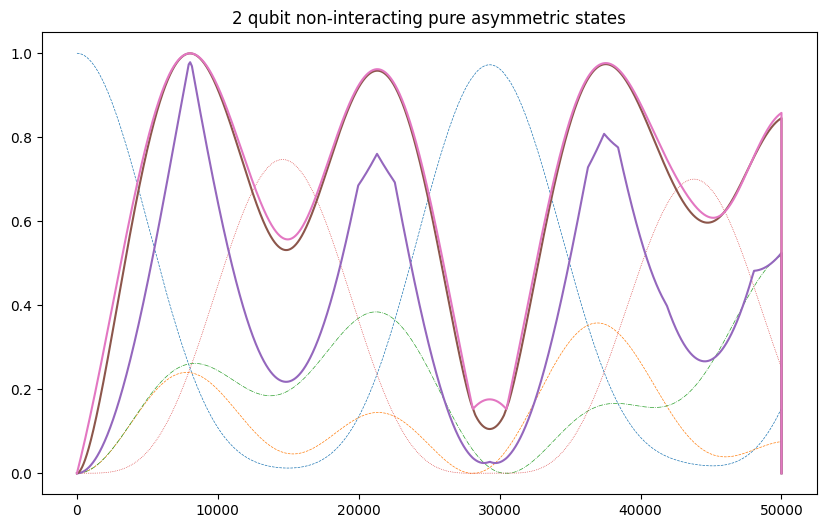

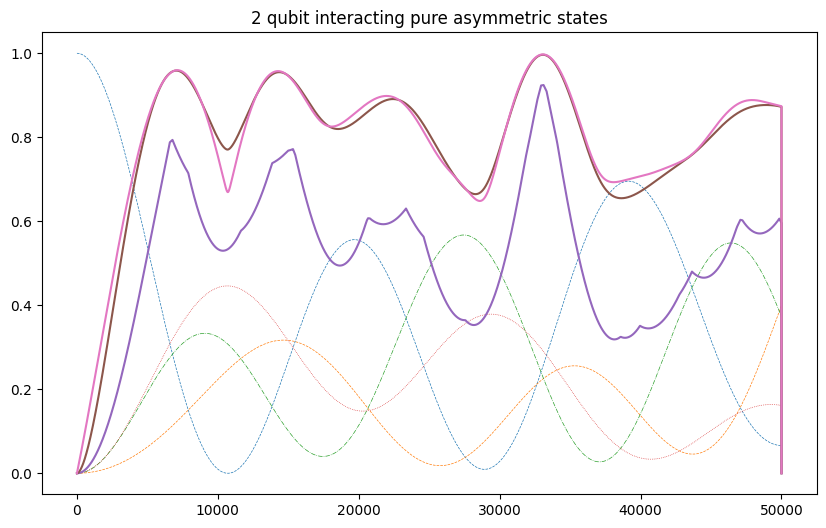

array([0.00000000e+00, 0.00000000e+00, 4.99999998e-08, ...,
       5.95880317e-01, 5.95813823e-01, 0.00000000e+00])

In [6]:
def interacting_Hamiltonian(H1, H2):
    return np.kron(H2, H1)

def non_interacting_Hamiltonian(H1, H2):
    return np.kron(H2, np.eye(H1.shape[0])) + np.kron(np.eye(H2.shape[0]), H1)

def Hamiltonian(delta):
    return np.array([
        [delta, 1],
        [1, 0]], dtype = complex
    )


H1 = Hamiltonian(0)
 
evolve_density_matrix(non_interacting_Hamiltonian(H1,H1), p, 0.0001, 50000, ptype="2 qubit non-interacting pure symmetric states") 
evolve_density_matrix(interacting_Hamiltonian(H1,H1), p, 0.0001, 50000, ptype="2 qubit interacting pure symmetric states")


H1 = Hamiltonian(1)
H2 = Hamiltonian(0.5)
 
evolve_density_matrix(non_interacting_Hamiltonian(H1,H2), p, 0.0001, 50000, ptype="2 qubit non-interacting pure asymmetric states")
evolve_density_matrix(interacting_Hamiltonian(H1,H2), p, 0.0001, 50000, ptype="2 qubit interacting pure asymmetric states")

C:\Users\91953\AppData\Local\Temp\ipykernel_17204\2144333667.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  C_re[step] = relative_entropy_of_coherence(rho)


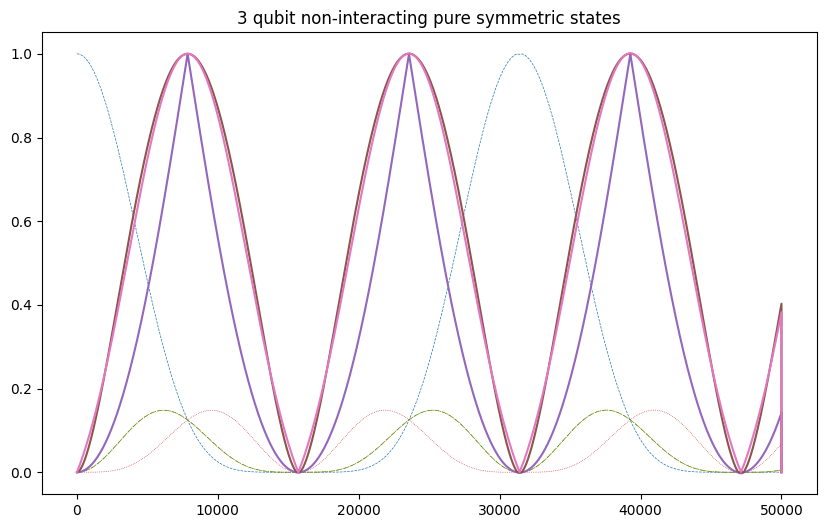

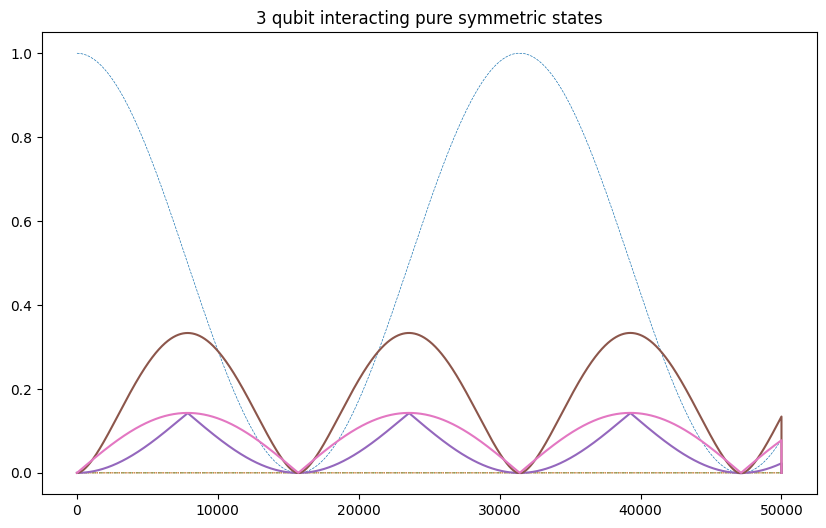

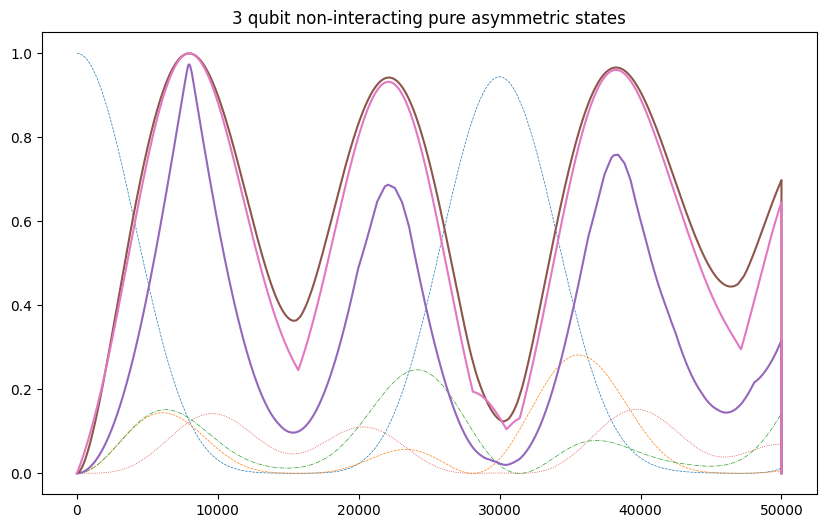

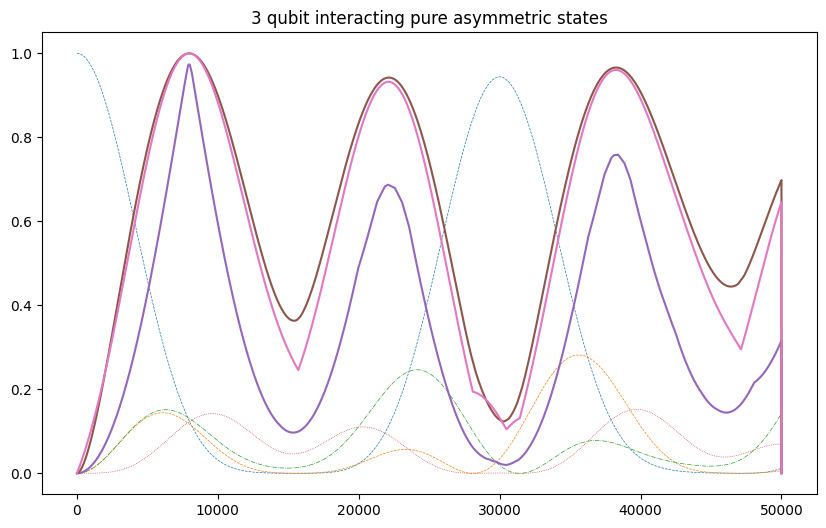

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99999940e-01, 2.00000000e-08, 2.00000000e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.21726824e-02, 6.02415963e-03, 1.42509365e-01, ...,
        2.03221937e-02, 4.77303619e-01, 2.30764984e-01],
       [1.21866385e-02, 6.02862966e-03, 1.42566145e-01, ...,
        2.03285248e-02, 4.77291255e-01, 2.30666340e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [10]:
H0 = Hamiltonian(0)
H1 = non_interacting_Hamiltonian(H0,H0)
H1 = non_interacting_Hamiltonian(H1,H0)
evolve_density_matrix(H1, p, 0.0001, 50000,3, "3 qubit non-interacting pure symmetric states")
H1 = interacting_Hamiltonian(H0,H0)
H1 = interacting_Hamiltonian(H1,H0)
evolve_density_matrix(H1, p, 0.0001, 50000,3, "3 qubit interacting pure symmetric states")


H1 = Hamiltonian(1)
H2 = Hamiltonian(0.5)
H1 = non_interacting_Hamiltonian(H1,H0)
H1 = non_interacting_Hamiltonian(H1,H2)
 
evolve_density_matrix(H1, p, 0.0001, 50000, 3, "3 qubit non-interacting pure asymmetric states")
H1 = Hamiltonian(1)
H2 = Hamiltonian(0.5)
H1 = non_interacting_Hamiltonian(H1,H0)
H1 = non_interacting_Hamiltonian(H1,H2)
evolve_density_matrix(H1, p, 0.0001, 50000, 3, "3 qubit interacting pure asymmetric states")


C:\Users\91953\AppData\Local\Temp\ipykernel_17204\243599459.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  C_re1[step] = relative_entropy_of_coherence(rho1)
C:\Users\91953\AppData\Local\Temp\ipykernel_17204\243599459.py:186: ComplexWarning: Casting complex values to real discards the imaginary part
  C_re2[step] = relative_entropy_of_coherence(rho2)


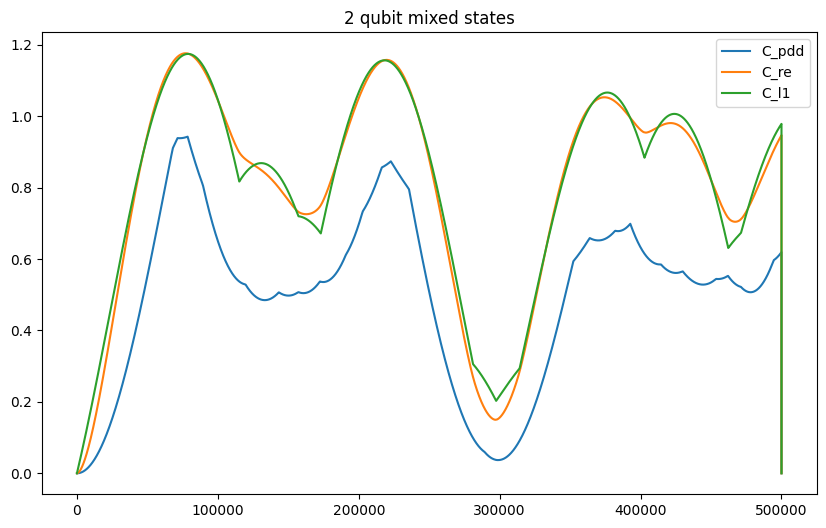

In [27]:
# H1 = non_interacting_Hamiltonian(Hamiltonian(0),Hamiltonian(0))
# H2 = interacting_Hamiltonian(Hamiltonian(0),Hamiltonian(1))

# evolve_density_matrix_mix(H1, p, 0.3, H2, p, 0.7, 0.00001, 500000, 2, "2 qubit mixed states")

C:\Users\91953\AppData\Local\Temp\ipykernel_17204\3872320536.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  C_re1[step] = relative_entropy_of_coherence(rho1)
C:\Users\91953\AppData\Local\Temp\ipykernel_17204\3872320536.py:173: ComplexWarning: Casting complex values to real discards the imaginary part
  C_re2[step] = relative_entropy_of_coherence(rho2)


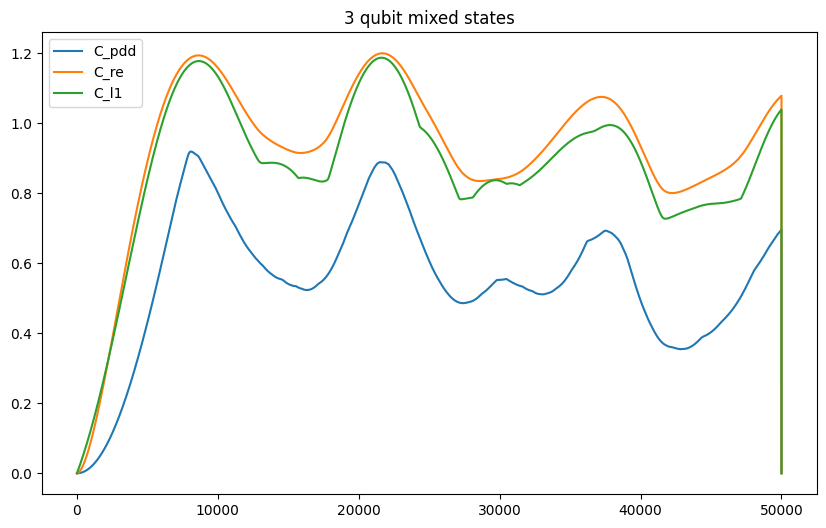

In [31]:
H1 = Hamiltonian(0)
H2 = Hamiltonian(1)
H3 = Hamiltonian(0.5)

H1 = non_interacting_Hamiltonian(H1,H2)
H1 = non_interacting_Hamiltonian(H1,H3)
H2 = interacting_Hamiltonian(H2,H2)
H2 = interacting_Hamiltonian(H2,H3)

evolve_density_matrix_mix(H1, p, 0.3, H2, p, 0.7, 0.0001, 50000, 3, "3 qubit mixed states")

C:\Users\91953\AppData\Local\Temp\ipykernel_20640\1943827306.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  C_re[step] = relative_entropy_of_coherence(rho)


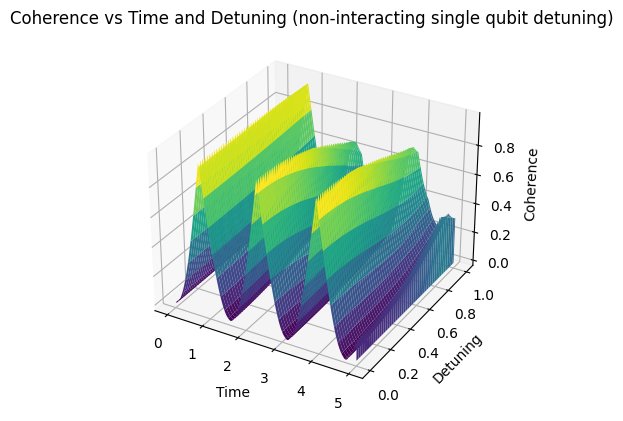

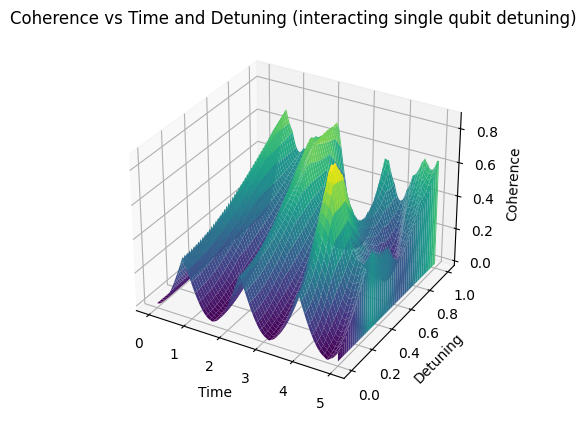

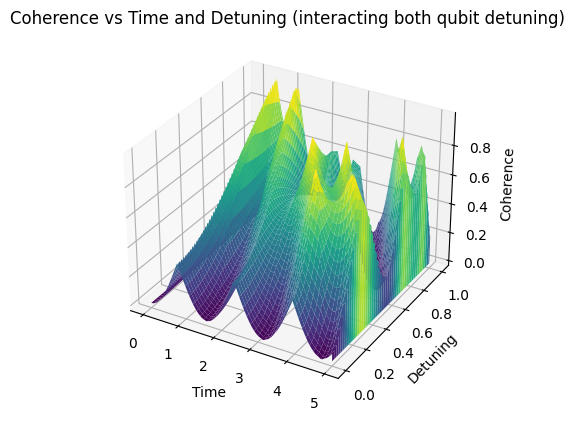

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Initialize the variables
H0 = Hamiltonian(0)
t_steps = 5000
dt = 0.001
x_steps = 100

# Time and detuning arrays
t = np.linspace(0, dt*t_steps, t_steps)
detuning = np.linspace(0, 1, x_steps)

# Initialize a 2D array to store coherence values
Coh = np.zeros((x_steps, t_steps))

# Calculate coherence for each detuning value
for i, d in enumerate(detuning):
    H1 = Hamiltonian(d)
    Coh[i, :] = evolve_density_matrix( non_interacting_Hamiltonian(H1,H0), p, dt, t_steps - 1, ptype="", plot=False)

# Create a meshgrid for detuning and time
T, D = np.meshgrid(t, detuning)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, D, Coh, cmap='viridis')

# Labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Detuning')
ax.set_zlabel('Coherence')
ax.set_title('Coherence vs Time and Detuning (non-interacting single qubit detuning)') 
plt.show()



Coh = np.zeros((x_steps, t_steps))

# Calculate coherence for each detuning value
for i, d in enumerate(detuning):
    H1 = Hamiltonian(d)
    Coh[i, :] = evolve_density_matrix( interacting_Hamiltonian(H1,H0), p, dt, t_steps - 1, ptype="", plot=False)

# Create a meshgrid for detuning and time
T, D = np.meshgrid(t, detuning)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, D, Coh, cmap='viridis')

# Labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Detuning')
ax.set_zlabel('Coherence')
ax.set_title('Coherence vs Time and Detuning (interacting single qubit detuning)') 
plt.show()




Coh = np.zeros((x_steps, t_steps))

# Calculate coherence for each detuning value
for i, d in enumerate(detuning):
    H1 = Hamiltonian(d)
    Coh[i, :] = evolve_density_matrix(interacting_Hamiltonian(H1,H1), p, dt, t_steps - 1, ptype="", plot=False)

# Create a meshgrid for detuning and time
T, D = np.meshgrid(t, detuning)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, D, Coh, cmap='viridis')

# Labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Detuning')
ax.set_zlabel('Coherence')
ax.set_title('Coherence vs Time and Detuning (interacting both qubit detuning)') 
plt.show()


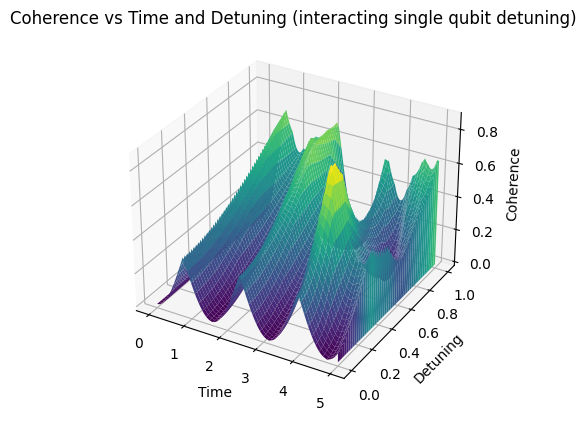

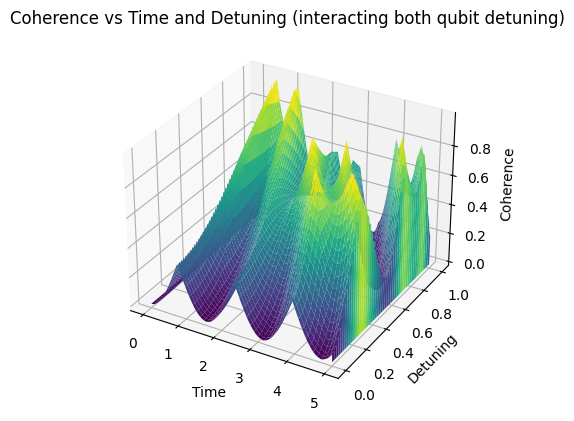

In [20]:
from mpl_toolkits.mplot3d import Axes3D

# Initialize the variables
H0 = Hamiltonian(0)
t_steps = 10000
dt = 0.0005
x_steps = 500

# Time and detuning arrays
t = np.linspace(0, dt*t_steps, t_steps)
detuning = np.linspace(0, 1, x_steps)





Coh = np.zeros((x_steps, t_steps))

# Calculate coherence for each detuning value
for i, d in enumerate(detuning):
    H1 = Hamiltonian(d)
    Coh[i, :] = evolve_density_matrix( interacting_Hamiltonian(H1,H0), p, dt, t_steps - 1, ptype="", plot=False)

# Create a meshgrid for detuning and time
T, D = np.meshgrid(t, detuning)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, D, Coh, cmap='viridis')

# Labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Detuning')
ax.set_zlabel('Coherence')
ax.set_title('Coherence vs Time and Detuning (interacting single qubit detuning)') 
plt.show()




Coh = np.zeros((x_steps, t_steps))

# Calculate coherence for each detuning value
for i, d in enumerate(detuning):
    H1 = Hamiltonian(d)
    Coh[i, :] = evolve_density_matrix(interacting_Hamiltonian(H1,H1), p, dt, t_steps - 1, ptype="", plot=False)

# Create a meshgrid for detuning and time
T, D = np.meshgrid(t, detuning)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, D, Coh, cmap='viridis')

# Labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Detuning')
ax.set_zlabel('Coherence')
ax.set_title('Coherence vs Time and Detuning (interacting both qubit detuning)') 
plt.show()
